<a href="https://colab.research.google.com/github/GawainGan/Causal-Inference/blob/main/Causal%20Inference%20and%20Discovery%20in%20Python/Chap_7_DoWhy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### packages

In [ ]:
# pip install econml

In [2]:
pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 12.9 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [3]:
dowhy.__version__

'0.11.1'

In [9]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Example 1

### Generate the data

In [5]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:

    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.infty, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.infty, scale=4)

    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)

        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)

        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u

        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u

        return gps, hippocampus, memory

    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [6]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([gps_obs, hippocampus_obs, memory_obs]).T, columns=['X', 'Z', 'Y'])

In [7]:
df.head()

,X,Z,Y
0,3.401110,-1.819536,-1.176714
1,2.003995,-0.939901,-0.465969
2,12.675572,-8.188005,-5.555301
3,11.312860,-6.871732,-4.291241
4,9.060915,-5.547674,-3.118411


## Step 1 – modeling the problem

1. Creating a graph representing our problem
2. Instantiating DoWhy’s CausalModel object using this graph

DAG for the generated data:
    
    U: Confounder, Motivation
    X: GPS Usage
    Z: Hippocampus
    Y: Spatical Memory

    +----- U -------+
    |               |
    |               |
    +-> X --> Z --> Y  

###1.1 Creating the graph

We did not include the confounding variable in our dataset (it’s unobserved!), but we’ll include it in the graph.

This will allow DoWhy to recognize that **there’s an unobserved confounder in the graph** and **find a relevant estimand** for us automatically.

In [8]:
# Create the graph describing the causal structure
gml_graph = """
graph [
    directed 1

    node [
        id "X"
        label "X"
    ]
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]

    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "Y"
    ]
    edge [
        source "U"
        target "X"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

### Step 1.2 - define the DoWhy model

In [9]:
# import logging

# # Configure the logging level to `logging.WARNING` or higher for additional details.
# logging.basicConfig(level=logging.DEBUG, format='%(message)s')

import warnings
warnings.filterwarnings('ignore')

In [10]:
# With graph
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_graph
)

logging result from the fitted Causal Model:
1. The graph defines 4 variables. 3 were found in the dataset and will be analyzed as observed variables.
2. 1 were not found in the dataset and will be analyzed as unobserved variables.
3. The observed variables are: '['X', 'Y', 'Z']'.
4. The unobserved variables are: '['U']'. If this matches your expectations for observations, please continue.

If you expected any of the unobserved variables to be in the dataframe, please check for typos.



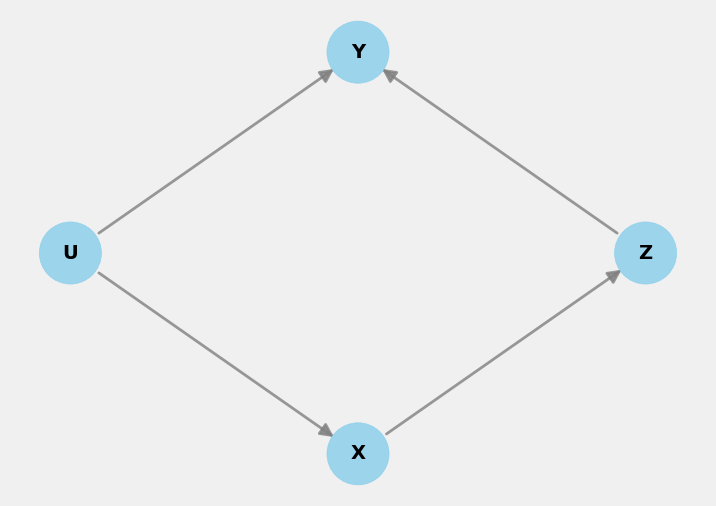

In [11]:
model.view_model(size=(8,6))

## Step 2 – identifying the estimand(s)

In [12]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
No such variable(s) found!

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)



DoWhy has found only one estimand for our graph: frontdoor

it will only be able to find estimands for us if our model is identifiable using one of the three supported methods

Reference for more advanced identification strategies: [grapl-causal](https://github.com/max-little/GRAPL)

## Step 3: Estimate the causal effect

### Example 1 - Linear Regression

for the general methods to estimate effect, here are some example:

    - Propensity Score Matching: "backdoor.propensity_score_matching"
    - Propensity Score Stratification: "backdoor.propensity_score_stratification"
    - Propensity Score-based Inverse Weighting: "backdoor.propensity_score_weighting"
    - Linear Regression: "backdoor.linear_regression"
    - Generalized Linear Models (e.g., logistic regression): "backdoor.generalized_linear_model"
    - Instrumental Variables: "iv.instrumental_variable"
    - Regression Discontinuity: "iv.regression_discontinuity"
    - Two Stage Regression: "frontdoor.two_stage_regression"

In [13]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='frontdoor.two_stage_regression')
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([Z])⎥
 ⎣d[Z]    d[X]     ⎦
Estimand assumption 1, Full-mediation: Z intercepts (blocks) all directed paths from X to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{X} and U→{Z} then P(Z|X,U) = P(Z|X)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{Z} and U→Y then P(Y|Z, X, U) = P(Y|Z, X)

## Realized estimand
(b: Z~X)*(b: Y~Z+X)
Target units: ate

## Estimate
Mean value: -0.4615111065157206



In [14]:
estimate.params

{'estimand_type': <EstimandType.NONPARAMETRIC_ATE: 'nonparametric-ate'>,
 'estimator_class': dowhy.causal_estimators.two_stage_regression_estimator.TwoStageRegressionEstimator,
 'test_significance': None,
 'evaluate_effect_strength': False,
 'confidence_intervals': False,
 'target_units': 'ate',
 'effect_modifiers': []}

In [15]:
significance_results = estimate.test_stat_significance()
p_value = significance_results["p_value"]
print(f"p-value: {p_value}")

p-value: (0.999, 1)


In [16]:
confidence_interval = estimate.get_confidence_intervals()
print(f"Confidence Intervals:{confidence_interval}")

Confidence Intervals:(-0.5013539093477959, -0.4204289389232797)


In [17]:
estimate.interpret()

Increasing the treatment variable(s) [X] from 0 to 1 causes an increase of -0.4615111065157206 in the expected value of the outcome [['Y']], over the data distribution/population represented by the dataset.


In [18]:
estimate.get_standard_error()

0.020879592032508196

In [19]:
print(f"Control Value: {estimate.control_value}\n"
      f"Treatment Value: {estimate.treatment_value}\n"
      f"Effect Strength: {estimate.effect_strength}\n"
      f"The Conditional Estimates: {estimate.conditional_estimates}\n"
      )

Control Value: 0
Treatment Value: 1
Effect Strength: None
The Conditional Estimates: None



In [20]:
#  we needed to fit two linear regression models, get their coefficients, and multiply them in order to obtain the final causal effect estimate

print(f'Estimate of causal effect (linear regression): {estimate.value}')

Estimate of causal effect (linear regression): -0.4615111065157206


## Step 4: Run refutation tests 反驳测试 (Where’s my validation set?)

证伪测试的基本思想是修改模型或数据集的某个元素，观察其对结果的影响

两种可用的转换类型：

1.	不变转换（Invariant Transformations）：不变转换以一种不应改变估计结果的方式改变数据。如果估计结果发生了显著变化，那么模型就未能通过测试。
2.	归零转换（Nullifying Transformations）：归零转换以一种应使估计效应为零的方式改变数据。如果结果显著偏离零，那么模型就未能通过测试。

**随机共同原因检验器（Random Common Cause Refuter）**：这个检验器会向数据集中添加一个新的混淆变量，并对其进行控制。如果原始模型正确地指定了，我们预计这样的添加不会导致模型估计发生显著变化（因此，这个测试属于不变转换类别）。

**应用示例**

假设我们有一个因果模型，用于估计某种治疗（Treatment）对结果（Outcome）的影响。我们可以进行以下类型的证伪测试：

1.	不变转换：比如对数据进行某种变换（如添加无关变量或重新排列数据），但这些操作不应该影响结果的估计。如果模型是稳健的，估计结果应该不变。
2.	归零转换：比如通过人工构造一个数据集，理论上应使治疗效果为零。如果在这个新的数据集上，模型仍然得出显著的效果，那么说明模型可能存在问题。

In [21]:
refute_subset = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name="data_subset_refuter",
    subset_fraction=0.4)

# This test removes a random subset of the data and re-estimates the causal effect.
# In expectation, the new estimate (on the subset) should not significantly differ from the original one.

In [22]:
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.4615111065157206
New effect:-0.4616030634363773
p value:0.98



Estimated effect和New effect非常接近，p值很高，这表明这两个估计值之间可能没有真正的差异。

这个结果没有伪造我们的假设，也许让我们更有信心我们的模型可能是正确的。

# Example 2

### Step 1 – encode the assumptions

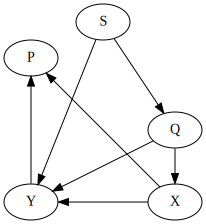

In [23]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['S', 'Q', 'X', 'Y', 'P']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!', '1.7,0.9!']

edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_07_full_example')

graph

In [24]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [26]:
# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [27]:
print(gml_string)

graph [directed 1
	node [id "S" label "S"]
	node [id "Q" label "Q"]
	node [id "X" label "X"]
	node [id "Y" label "Y"]
	node [id "P" label "P"]
	edge [source "S" target "Q"]
	edge [source "S" target "Y"]
	edge [source "Q" target "X"]
	edge [source "Q" target "Y"]
	edge [source "X" target "P"]
	edge [source "Y" target "P"]
	edge [source "X" target "Y"]
]


In [28]:
# Instantiate the CausalModel
model = CausalModel(
    data=df,
    treatment='X',
    outcome='Y',
    graph=gml_string
)

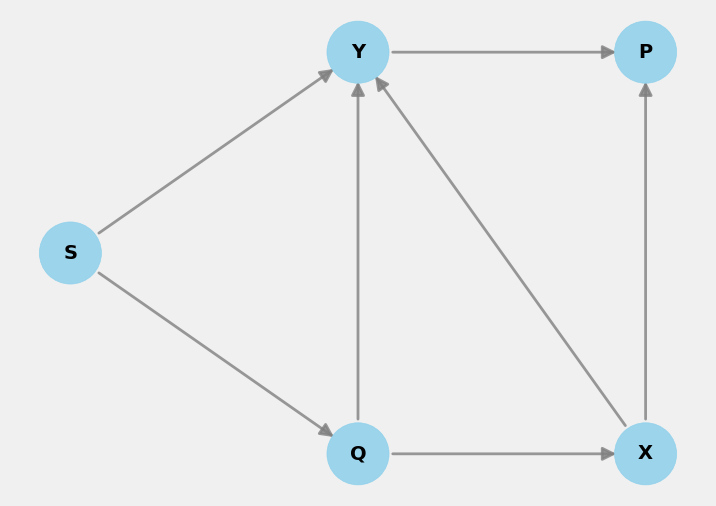

In [29]:
model.view_model()

### 2. Identify Effect

In [30]:
# Get the estimand
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Q])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Q,U) = P(Y|X,Q)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 72.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 2.7 MB/s eta 0:00:00


### 3. Estimate Effect

In [35]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

Estimate of causal effect (DML): 0.7348394732499146


In [36]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')

Estimate of causal effect (linear regression): 0.7233933946119362


### 4.Refutation Test

In [37]:
random_cause = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
)

In [38]:
print(random_cause)

Refute: Add a random common cause
Estimated effect:0.7348394732499146
New effect:0.7215718494344027
p value:0.54



- **Refute: Add a random common cause** ：数据集中添加一个随机生成的共同原因（混淆变量）并控制它，来检查模型的估计是否会发生显著变化。理论上，如果模型是正确的，并且已经考虑了所有的混淆因素，添加这个随机共同原因不应该显著改变估计结果
- **Estimated Effect** 和 **New Effect**：两个数据的区别非常小，即添加了随机生成的共同原因，造成的影响很像。即改生成数据对实际模型不产生显著效果
- **P-value**：该数值没有<0.05，即无法拒绝原假设。原假设为：**新效应值与原始效应值之间的差异仅是由于随机因素引起的，不存在实际的显著差异**。因此同样再次验证了**Estimated Effect** 和 **New Effect** 两者差值的分析结果

因此，结果表明，随机共同原因的添加没有显著影响因果效应的估计值，模型的稳健性得到了支持

In [39]:
placebo_refuter = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

In [40]:
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:0.7348394732499146
New effect:0.0
p value:1.0



- **Refute: Use a Placebo Treatment**：这种方法通过将处理变量（Treatment）替换为一个“安慰剂变量”（Placebo Variable），该变量不应该对结果产生影响。然后，它检查这个替换是否会显著改变因果效应的估计
- **New effect:0.0**：这是在使用“安慰剂处理”后得到的新估计效应值。在这种情况下，安慰剂变量的效应估计为0.0。这意味着，当我们用一个不相关的安慰剂变量替代实际的处理变量时，模型正确地反映出没有效应，这表明模型是有效的
- **p value:1.0**：p值为1.0，表示新效应值（0.0）与原始效应值（在此情况下也是0.0）之间的差异完全不显著。这进一步确认了当使用安慰剂变量时，模型不会得出虚假的因果效应。

原假设（Null Hypothesis）
在这个安慰剂检验中，p值对应的原假设是：**安慰剂变量不会导致显著的因果效应估计。**

具体来说，原假设假定在将处理变量替换为安慰剂变量后，模型的因果效应估计值应为零，或至少不应显著偏离零。如果p值为1.0，这意味着没有证据表明安慰剂变量会导致显著的因果效应估计，这与预期一致。

结论

稳健性：这个输出表明，模型通过了安慰剂检验。安慰剂处理后的估计效应为0.0，p值为1.0，表明安慰剂变量未对模型产生任何虚假效应。这增强了对模型的信心，即实际的处理变量确实有影响，而这种影响不是由于模型中潜在的误差或噪声所引起的。



# GCM (graphical causal model)

In [3]:
import networkx as nx
from dowhy import gcm

In [6]:
SAMPLE_SIZE = 1000

S = np.random.random(SAMPLE_SIZE)
Q = 0.2*S + 0.67*np.random.random(SAMPLE_SIZE)
X = 0.14*Q + 0.4*np.random.random(SAMPLE_SIZE)
Y = 0.7*X + 0.11*Q + 0.32*S + 0.24*np.random.random(SAMPLE_SIZE)
P = 0.43*X + 0.21*Y + 0.22*np.random.random(SAMPLE_SIZE)

# Encode as a pandas df
df = pd.DataFrame(np.vstack([S, Q, X, Y, P]).T, columns=['S', 'Q', 'X', 'Y', 'P'])

In [7]:
edges = ['SQ', 'SY', 'QX', 'QY', 'XP', 'YP', 'XY']
graph_nx = nx.DiGraph([(edge[0], edge[1]) for edge in edges])

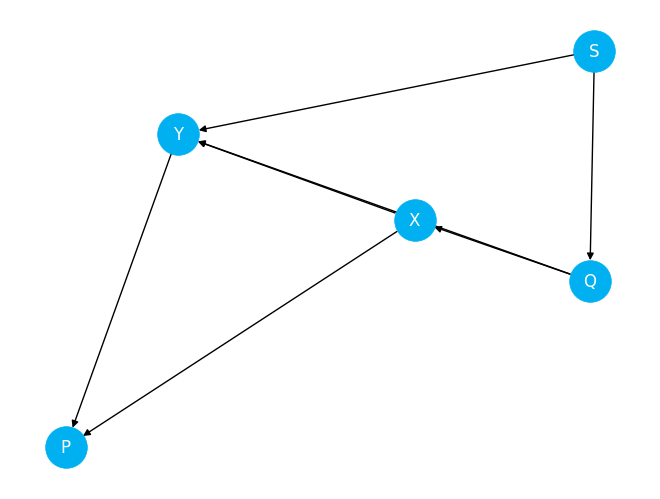

In [10]:
nx.draw(
    graph_nx,
    with_labels=True,
    node_size=900,
    font_color='white',
    node_color=COLORS[0]
)

**gcm.InvertibleStructuralCausalModel**：改模型允许我们在不需要手动指定所有噪声变量的情况下生成反事实样本。这种模型假设存在一个可逆的函数,将外生噪声变量映射到观察到的变量
- 允许从观察数据中推断噪声变量。
- 能够生成反事实样本,无需手动指定所有噪声变量。
- 支持各种因果推断任务,如计算平均处理效应、条件平均处理效应等



In [11]:
# This is the invertible SCM, since this is the only model that allows us to generate counterfactuals without manually providing values for all noise variables.
causal_model = gcm.InvertibleStructuralCausalModel(graph_nx)

1. 对于S变量:
   - S被设置为使用经验分布(Empirical Distribution)。
   - 原因: S是模型中唯一没有父节点的内生变量。
   - 经验分布的作用: 它直接从观察到的数据中估计S的分布,而不假设任何特定的参数分布形式。
   - 这种方法适用于我们不知道或不想假设S的具体生成机制的情况。

2. 对于其他变量(X, Y, P, Q):

   所有这些变量都使用了加性噪声模型(Additive Noise Model, ANM)和线性回归。

   - 加性噪声模型:
     - 形式: Y = f(X) + ε，其中f是一个确定性函数,ε是独立于X的噪声。
     - 这个模型假设因果关系可以被分解为一个确定性部分和一个随机噪声部分。
   
   - 线性回归:
     - 使用`gcm.ml.create_linear_regressor()`创建线性回归器。
     - 这表明我们假设变量之间的关系是线性的。
     - 例如,对于Y,可能的形式是: Y = β0 + β1X1 + β2X2 + ... + ε

   - 这种设置的优点:
     1. 简单性: 线性模型易于理解和解释。
     2. 计算效率: 线性模型的参数估计通常很快。
     3. 适用性: 在许多实际问题中,线性近似常常是一个好的起点。

   - 潜在的局限性:
     1. 可能无法捕捉复杂的非线性关系。
     2. 如果实际关系严重偏离线性,可能导致错误的因果推断。

3. 整体考虑:
   - 这种设置反映了对模型结构的假设: S是外生的,而其他变量是由它们的父节点以及一些随机噪声决定的。
   - 使用相同的机制(ANM + 线性回归)对所有内生变量简化了模型,但也可能是一个强假设。
   - 在实际应用中,可能需要根据领域知识或数据特征来调整这些假设。

In [12]:
# use gcm.EmpiricalDistribution() for S because it’s the only variable that does not have parents among endogenous variables
causal_model.set_causal_mechanism('S', gcm.EmpiricalDistribution())

# For all other variables, we set the causal mechanism to an additive causal model and use linear regression to model it.
causal_model.set_causal_mechanism('X', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Y', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('P', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))
causal_model.set_causal_mechanism('Q', gcm.AdditiveNoiseModel(gcm.ml.create_linear_regressor()))

gcm.fit(causal_model, df)

Fitting causal mechanism of node P: 100%|██████████| 5/5 [00:00<00:00, 58.24it/s]


In [13]:
gcm.arrow_strength(causal_model, 'Y')

{('Q', 'Y'): 0.0004796578464635075,
 ('S', 'Y'): 0.00866550633396674,
 ('X', 'Y'): 0.006952513701625396}

输出显示了指向Y的各个边的因果强度。从结果可以看出:

- S对Y的影响最大 (0.00867)
- 其次是X对Y的影响 (0.00695)
- Q对Y的影响最小 (0.00048)

这表明在影响Y的因素中,S是最重要的,其次是X,而Q的影响相对较小。


基于改结果我们可以在后续进行的操作：
- 变量重要性：帮助识别哪些变量对 Y 有最直接和强烈的影响。
- 干预策略：如果目标是改变 Y，这些结果建议首先考虑改变 S，其次是 X。
- 模型简化：在复杂模型中，可以考虑移除 Q → Y 这条边，因为其影响很小。
- 进一步研究方向：可能需要更深入地研究 S 和 Y 之间的关系。
- 预测和控制：在预测或控制 Y 时，应该更多地关注 S 和 X 的变化。

In [15]:
# 这一步生成了反事实样本。它假设X的值被设置为0.21,然后预测其他变量的值会如何变化。
gcm.counterfactual_samples(
    causal_model,
    {'X': lambda x: .21},
    observed_data=pd.DataFrame(data=dict(X=[.5], Y=[.75], S=[.5], Q=[.4], P=[.34])))

,S,Q,X,Y,P
0,0.5,0.4,0.21,0.549934,0.185891


1. 数据来源：
   - `observed_data` 中的字典是手动设置的一个观察样本。
   - 这不是基于之前生成的数据，而是一个假设的观察点。
   - 在实际应用中，这通常会是从真实数据集中选择的一个具体观察样本。

2. 反事实设置：
   - `{'X': lambda x: .21}` 定义了反事实干预：将 X 的值设置为 0.21。
   - 原始观察中 X 的值是 0.5，反事实将其改变为 0.21。

3. 生成的结果：

- S 和 Q 保持不变（0.5 和 0.4）
- X 被设置为 0.21（从 0.5 变化-这是我们做的干预）
- Y 变为约 0.55（从 0.75 变化）
- P 变为约 0.19（从 0.34 变化）

实际意义和操作：

1. 因果效应估计：这允许我们估计将 X 从 0.5 改变到 0.21 对 Y 和 P 的影响。

2. 政策评估：如果 X 代表一个可控制的变量（如政策强度），这个结果可以帮助预测政策改变的效果。

3. 预测：帮助理解在特定情况下改变一个变量会如何影响其他变量。

4. 假设检验：可以用来检验我们对系统行为的假设。

5. 个性化决策：在医疗、教育等领域，可以用来评估对特定个体采取某种干预的潜在效果。

6. 模型验证：通过比较反事实预测与实际观察，可以帮助验证因果模型的准确性。

7. 敏感性分析：通过改变干预的强度（例如，将 X 设置为不同的值），可以分析系统对不同程度干预的敏感性。

注意：这个例子中只生成了一个反事实样本。在实际应用中，通常会生成多个样本以获得更稳健的估计和置信区间。

将 X 设置为 0.21（从原始的 0.5 变化）是一个人为设定的干预。这种做法有几个重要的原因和意义：

1. 模拟干预：
   - 这模拟了我们在现实世界中可能采取的一个行动或政策变化。
   - 例如，如果 X 代表某种治疗的剂量，这相当于我们将剂量从 0.5 单位减少到 0.21 单位。

2. 反事实推理：
   - 这允许我们回答"如果"类型的问题：如果我们将 X 改变为 0.21，会发生什么？
   - 这是因果推断的核心，允许我们超越纯粹的观察数据，探索潜在的因果关系。

3. 估计因果效应：
   - 通过比较干预前后的结果，我们可以估计 X 对其他变量（如 Y 和 P）的因果效应。
   - 这有助于我们理解系统中的因果机制。

4. 政策评估：
   - 在决策制定中，这种分析可以帮助预测政策改变的潜在影响。
   - 例如，如果 X 代表税率，这可以帮助评估降低税率的潜在经济影响。

5. 探索非线性关系：
   - 通过选择不同的干预值（如从 0.5 到 0.21），我们可以探索变量间可能存在的非线性关系。
   - 这对于理解复杂系统中的动态很重要。

6. 验证模型：
   - 如果我们有关于实际干预结果的数据，这种模拟可以用来验证我们的因果模型的准确性。

7. 敏感性分析：
   - 通过尝试不同的干预值，我们可以分析系统对不同程度变化的敏感性。
   - 这有助于理解系统的稳定性和弹性。

8. 个性化预测：
   - 在医疗或教育等领域，这种分析可以用于预测特定干预对个体的潜在影响。

9. 伦理考虑：
   - 在某些情况下，实际进行干预可能不道德或不可行。反事实分析提供了一种安全的替代方法。

10. 假设检验：
    - 这允许我们检验关于系统行为的假设，而无需实际改变系统。

在这个特定的例子中，选择 0.21 这个值可能是为了展示一个显著的变化（从 0.5 减少到 0.21，大约减少了 58%）。在实际应用中，干预的值通常基于具体的研究问题、领域知识或实际可行的干预范围来选择。